# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Curvature penalized models

In this notebook, we run some TTI models (Tilted Transversely Anisotropic), a kind of Finslerian manifold appearing in seismology, on the CPU and GPU, and check that they produce consistent results.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Defining a seismic norm, and calling the gpu code](#1.1-Defining-a-seismic-norm,-and-calling-the-gpu-code)
    * [1.2 The Riemannian approximation](#1.2-The-Riemannian-approximation)
    * [1.3 Comparison with the CPU code](#1.3-Comparison-with-the-CPU-code)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Seismic_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd.Metrics.Seismic import TTI
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,Metrics,TTI
    Eikonal,ad,cugen,Metrics,TTI = rreload([Eikonal,ad,cugen,Metrics,TTI],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

## 0.1 Additional configuration

In [110]:
large_instances=False # True favors the GPU code. CPU times may get a bit long

## 1. Two dimensions

### 1.1 Defining a seismic norm, and calling the gpu code

In [69]:
n=1000
hfmIn = Eikonal.dictIn({
    'model':'TTI2',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seed':[0.,0.],
    'factoringRadius':20,
    'count_updates':True,
#    'traits':{'niter_i':10},'fim_front_width':6, # Optional. Improves GPU time a bit. (40%)
    
})

hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True) # Define the domain
X = hfmIn.Grid() # Horizontal and vertical axis

lin = cp.array([1.,2.])
#quad = xp.zeros((2,2))
quad = -cp.array([[0.,0.2],[0.2,0.]])
#quad = xp.array([[0.5,0.1],[0.1,-0.2]])
metric = TTI(lin,quad,vdim=2).rotate_by(cp.array(0.5)) #Linear and quadratic part
hfmIn['metric'] = metric

In [71]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
#define Scalar_macro
typedef float Scalar;
#define Int_macro
typedef int Int;
#define OffsetT_macro
typedef int OffsetT;
#define pruning_macro false
#define shape_i_macro
const int shape_i[2] = {8,8};
#define niter_i_macro
const int niter_i=10;
#define nmix_macro 7
#define multiprecision_macro false
#define factor_macro true
#define ndim_macro 2
#define fim_macro true
#define geom_indep_macro 2
#define import_scheme_macro false
#define local_i_macro true
#define periodic_macro false
#define isotropic_macro false
#define walls_macro false
const int size_i = 64;
const int log2_size_i = 6;
#include "TTI_.h"
// Date cuda code last modified : 1602748496.237121

Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.41249608993530273 seconds, and 209 iterations.
Post-Processing


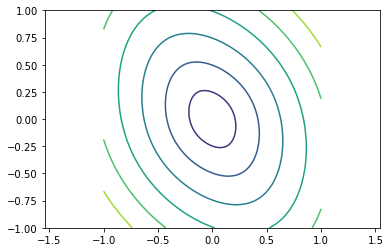

In [15]:
plt.axis('equal')
plt.contour(*X,hfmOut['values']);

We are here defining a constant norm over the domain, hence the exact solution can be computed directly for reference.

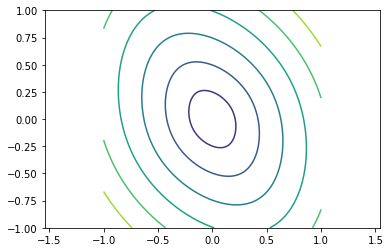

In [9]:
plt.axis('equal')
plt.contour(*X,metric.norm(X));

### 1.2 The Riemannian approximation

In [14]:
riemIn = hfmIn.copy()
riemIn['model'] = 'Riemann2'
riemIn['metric'] = metric.Riemann_approx() # Metrics.Riemann.from_diagonal(1/lin).rotate_by(cp.array(0.5))
riemOut = riemIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.13997101783752441 seconds, and 149 iterations.
Post-Processing


The CPU time for the TTI model is, on large instances, typically 30 times the one of the Riemannian model. This exceeds the expected scaling of $10 \times$ due to the fact that the TTI norm is expressed as an extremum of 10 riemannian norms. (Some investigation is needed.)

The number of block updates is similar.

In [15]:
np.mean(hfmOut['stats']['eikonal']['nupdate_o']),np.mean(riemOut['stats']['eikonal']['nupdate_o'])

(array( 13.9), array(   17))

The Riemannian approximation is not very far, yet the distinct shape of the level sets is clearly visible.

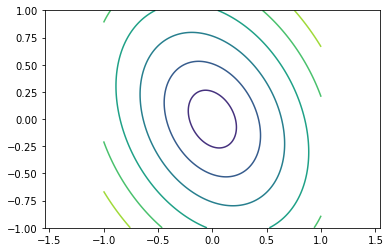

In [16]:
plt.axis('equal')
plt.contour(*X,riemOut['values'])

### 1.3 Comparison with the CPU code

The CPU code implements the operator in a different manner, using a Newton method rather than an exhaustive search to find the optimal ellipse. It agrees quite well with the GPU code, at second order w.r.t. the number of ellipses used.

In [13]:
gpuOut,cpuOut = RunCompare(hfmIn,check=1e-3)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.6184728145599365 seconds, and 139 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 14.283 s.
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.6184728145599365, CPU : 15.482999999999999. Device acceleration : 25.034245055729176
Max |gpuValues-cpuValues| :  0.0008317169852170014


The number of ellipses used in the envelope of the TTI norm is defined as the following trait.
The GPU code can be accelerated by reducing it, at the possible expense of accuracy.

In [14]:
gpuOut['keys']['default']['traits']['nmix_macro']

7

In [15]:
hfmIn5 = hfmIn.copy(); hfmIn5['traits'] = hfmIn5.get('traits',{}).copy()
hfmIn5['traits']['nmix_macro'] = 5 # Use 5 ellipses for the envelope

In [16]:
gpuOut5 = hfmIn5.Run()
np.max(np.abs(gpuOut5['values'].get() - cpuOut['values']))

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.42447614669799805 seconds, and 139 iterations.
Post-Processing


0.00167503114087042

## 2. Three dimensions

In [108]:
n=200 if large_instances else 100
hfmIn = Eikonal.dictIn({
    'model':'TTI3',
    'exportValues':1,
    'seed':[0.,0.,0.],
    'factoringRadius':20,
    'seedRadius':2,
#    'traits':{'niter_i':3},'fim_front_width':6, # Optional : improves a bit gpu time when n=200. (25%) 
})

hfmIn.SetRect(sides=[[-1,1],[-1,1],[-1,1] ],dimx=n+1,sampleBoundary=True) # Define the domain
X = hfmIn.Grid() 

metric = TTI(lin,quad,vdim=3).rotate_by(cp.array(0.5),axis=cp.array((1,2,3.)))
hfmIn['metric'] = metric

In [20]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.008)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.9624729156494141 seconds, and 48 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Fast marching solver completed in 44.654 s.
Solver time (s). GPU : 0.9624729156494141, CPU : 48.091. Device acceleration : 49.966081349469796
Max |gpuValues-cpuValues| :  0.005979479891046635


The CPU and GPU implementations are fairly distinct, using either brute force or a Newton method to solve the local problems.
Yet their solutions are extremely close, showing that they do solve the same discrete problem.

In [22]:
error = np.abs(cpuOut['values'] - gpuOut['values'].get())
np.max(error), np.mean(error)

(0.005979479891046635, 0.0021988653566339307)

In particular, they are much closer to one anoher than to the exact solution, which is known in the case of a constant metric.

In [23]:
exact = metric.norm(X)

In [24]:
np.max(np.abs(exact - gpuOut['values']))

array(0.0155, dtype=float32)

In [25]:
np.max(np.abs(exact.get() - cpuOut['values']))

0.01054677412905658